<a href="https://colab.research.google.com/github/juanalverto/Image-style-transfer/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
#Disable eager execution
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

# Ruta donde se almacena la imagen que quieres transformar (contenido)
target_image_path = '/content/drive/My Drive/Style_Transfer/Guanajuato.png'

# Ruta donde se almacena la imagen de estilo
style_reference_image_path = '/content/drive/My Drive/Style_Transfer/Starry_Night.jpg'

# Dimensiones de la imagen generada
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Using TensorFlow backend.


In [ ]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
   # Centrar en cero
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
from keras import backend as K

#Definimos la imagen objetivo y la imagen de referencia de estilo
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# Este placeholder contendrá nuestra imagen generada
combination_image = K.placeholder((1, img_height, img_width, 3))

# Combinamos las 3 imágenes en un solo batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# Cargamos la red VGG19 con nuestro batch de 3 imágenes como entrada.
# El modelo se cargará con los pesos pre-entrenados en ImageNet
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

80142336/80134624 [==============================] - 2s 0us/step
Model loaded.


In [ ]:
#Definimos la función de pérdida para el contenido
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [ ]:
#Definimos la función de pérdida para la imágen de estilo
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [ ]:
#Definimos la pérdida de variación total
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [ ]:
# Diccionario que asocia los nombres de las capas con sus activaciones correspondientes
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Nombre de la capa usada por la pérdida del contenido
content_layer = 'block5_conv2'

# Nombre de las capas usadas para la pérdida de la imagen de estilo
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Pesos que tendrá cada componente de la pérdida
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Definimos la pérdida añadiendo todos los componentes a la variable 'loss'
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [ ]:
# Gradiente de la imagen generada con respecto a la pérdida
grads = K.gradients(loss, combination_image)[0]

# Función para extraer los valores actuales de los pesos y de los gradientes
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

# Descenso de gradiente
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [ ]:
from scipy.optimize import fmin_l_bfgs_b
import imageio
import time

result_prefix = 'style_transfer_result'
iterations = 20

# Ejecutamos el algoritmo de optimización de scipy L-BFGS sobre los píxeles
# de la imagen generada buscando minimizar la pérdida neuronal del estilo.
# Este es nuestro punto inicial: la imagen contenido.
# Observar que `scipy.optimize.fmin_l_bfgs_b` sólo trabaja con vectores aplanados.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Guardar la imagen generada actual
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imageio.imwrite(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1164658300.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 19s
Start of iteration 1
Current loss value: 532703200.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 8s
Start of iteration 2
Current loss value: 362209540.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 9s
Start of iteration 3
Current loss value: 268663580.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 9s
Start of iteration 4
Current loss value: 224970690.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 9s
Start of iteration 5
Current loss value: 196919550.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 9s
Start of iteration 6
Current loss value: 175046180.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 9s
Start of iteration 7
Current loss value

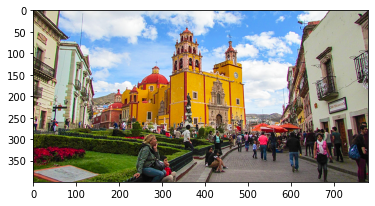

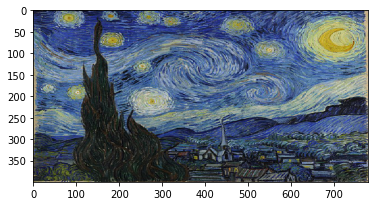

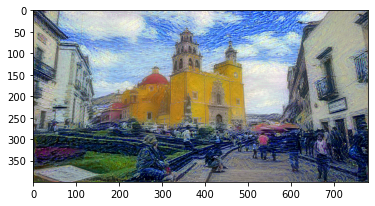

In [ ]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()

In [ ]:
imageio.imwrite('/content/drive/My Drive/Style_Transfer/Guanajuato_style_transfer.jpg',img)